# Machine Learning Demo on NLSY Data

First, import the relevant files and set up the cohort dataframes...

In [1]:
import nlsy
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import brier_score_loss

%matplotlib inline

NLSY_db = nlsy.NLSY_database("data.db")
(cohort_79, cohort_97) = NLSY_db.cohorts
data_79 = cohort_79.data(impute_values=True)
data_97 = cohort_97.data(impute_values=True)

Then, ensure that each cohort's dataframe includes the same columns. (This is necessary because some industry/occupation codes are used within only one of the two cohorts.)

In [2]:
for col in data_79.columns:
    if not col in data_97.columns:
        data_97[col] = 0
        
for col in data_97.columns:
    if not col in data_79.columns:
        data_79[col] = 0

Next, create the merged data incorporating the samples from both cohorts, define the predictor variables (in this case, we're using everything *except* case_id and sample_id, which are housekeeping variables, and the year, which is not relevant to predictions about future income shock risk), and create "test" and "train" samples.

For the purpose of this example, our training set consists of 80% of the instances across *both* cohorts. We can, of course, experiment with training models only on one cohort and then using each to predict the other.

In [3]:
merged_data = pd.concat([data_79, data_97], sort=False)
merged_data.drop(merged_data[merged_data["adjusted_income"] <= 1000].index, inplace=True)
merged_data.fillna(0, inplace=True)

predictors = list(merged_data.columns)
vars_to_drop = ["case_id", "sample_id", "year", "shock", "region", "highest_grade", "industry", "occupation"]
for var in vars_to_drop:
    predictors.remove(var)
    
X_train, X_test, y_train, y_test = train_test_split(merged_data[predictors], merged_data["shock"], test_size = 0.2)

Because we're dealing with an imbalanced class (only ~20% of people suffer an income shock in a given year), F1 score is a relatively poor way of evaluating the model. Even a naive prediction that no one ever suffers an income shock would be right 80% of the time!

To better measure the skill of our model, then, it's important to establish a baseline. The below code provides a classification report for a "dummy" predictor that presumes no one ever has an income shock, as well as a [Brier skill reference](https://www.statisticshowto.datasciencecentral.com/brier-score/) for a "dummy" predictor that assigns everyone an *equal* chance of an income shock (that is, the ~20% average risk seen in the data).

In [4]:
dummy_predictions = np.full((len(X_test), 1), merged_data["shock"].median())
dummy_probs = np.full((len(X_test), 1), merged_data["shock"].mean())
dummy_report = classification_report(y_test, dummy_predictions, target_names=["No shock","Shock"])
print(dummy_report)

brier_skill_ref = brier_score_loss(y_test, dummy_probs)
print("The Brier score of the dummy predictor is {:.03f}.".format(brier_skill_ref))

              precision    recall  f1-score   support

    No shock       0.76      1.00      0.87     28215
       Shock       0.00      0.00      0.00      8735

   micro avg       0.76      0.76      0.76     36950
   macro avg       0.38      0.50      0.43     36950
weighted avg       0.58      0.76      0.66     36950

The Brier score of the dummy predictor is 0.181.


/home/lucas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


With all of that prep work completed, we can now deploy a real machine learning model on the data set -- in this case, a random forest classifier.

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing, tree

Run the Decisiontree classifier on the train data and test the accuracy using the test data.


In [6]:
dtc = tree.DecisionTreeClassifier()

In [7]:
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

Check for accuracy

In [8]:
accuracy = dtc.score(X_test, y_test)
print("Random Forest Accuracy = ",accuracy)

Random Forest Accuracy =  0.6690121786197565


classification report



In [9]:
target_names = ['No Shock', 'Shock']
clr = classification_report(y_test, y_pred, target_names=target_names)
print(clr)

              precision    recall  f1-score   support

    No Shock       0.79      0.77      0.78     28215
       Shock       0.31      0.33      0.32      8735

   micro avg       0.67      0.67      0.67     36950
   macro avg       0.55      0.55      0.55     36950
weighted avg       0.68      0.67      0.67     36950



In [10]:
y_predictions = dtc.predict_proba(X_test)[:,1]
dtc_score = brier_score_loss(y_test, y_predictions)
dtc_skill = (1 - (dtc_score / brier_skill_ref))
print("The Brier score of the Random Forrest Classifier is {:.03f}, translating to a Brier skill score of {:.03f}.".format(dtc_score, dtc_skill))

The Brier score of the Random Forrest Classifier is 0.331, translating to a Brier skill score of -0.834.


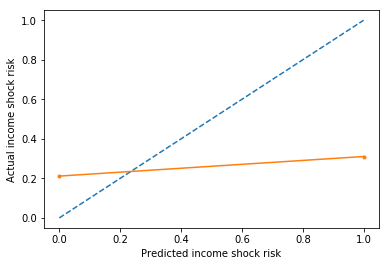

In [11]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
logreg_x, logreg_y = calibration_curve(y_test, y_predictions, n_bins=20)

# Plot a reference line showing what a perfectly calibrated model would look like.
plt.plot([0, 1], [0, 1], linestyle='--')

# Plot the model's actual reliability.
plt.plot(logreg_y, logreg_x, marker='.')

plt.ylabel('Actual income shock risk')
plt.xlabel('Predicted income shock risk')
plt.show()

In [12]:
# Function code copied from jhboyle's "1984_Congressional_Voting_Classification  THANKS!
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 15)
    plt.colorbar()    
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=0, size = 12)
    plt.yticks(tick_marks, target_names, rotation=90, size = 12)
    plt.tight_layout()
    plt.ylabel('True Label', size = 15)
    plt.xlabel('Predicted Label', size = 15)
    plt.savefig('plot_confusion_matrix')

Confusion matrix for un-scaled Random Forest
[[21852  6363]
 [ 5867  2868]]


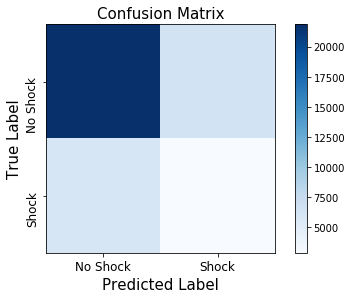

In [13]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix for un-scaled Random Forest')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

### Note that the confusion matrix uses y_pred because classification metrics can't handle a mix of binary and continuous targets

Normalized Confusion Matrix for Random Forest
[[0.77 0.23]
 [0.67 0.33]]


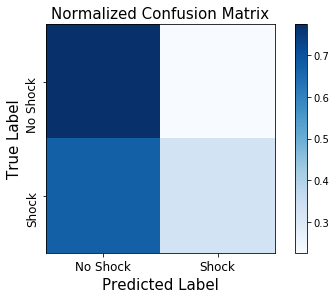

In [14]:
# Following jhboyle's example ...
# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized Confusion Matrix for Random Forest')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized Confusion Matrix')
plt.savefig('plot_norm_confusion_matrix')
plt.show()

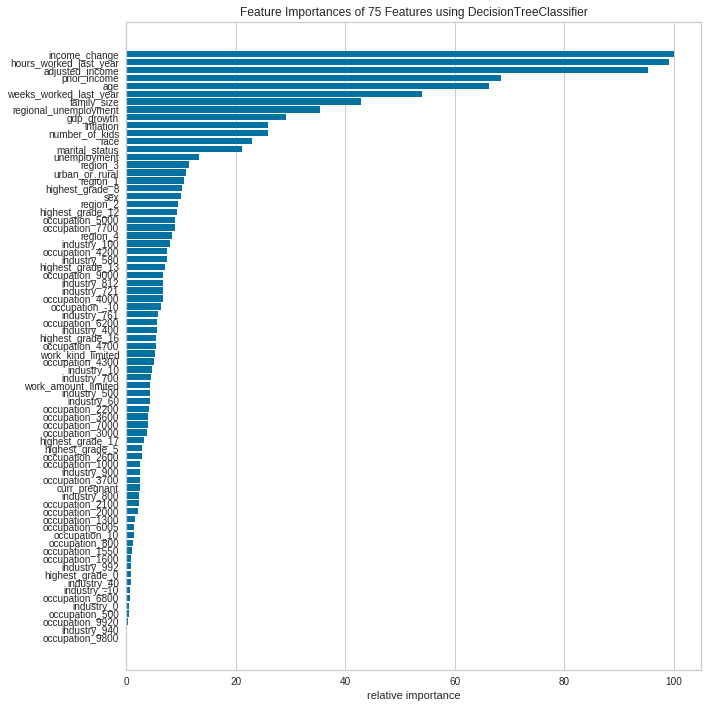

In [15]:
from yellowbrick.features.importances import FeatureImportances

# Create a new matplotlib figure
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(figsize=(10,10))

viz = FeatureImportances(dtc, ax=ax)
viz.fit(X_test, y_test)
viz.poof()

# How about Gaussian Naive Bayes Classifier?

In [16]:
# To try a Naive Bayes model, need to verify the train and test arrays are the same length
from sklearn.naive_bayes import GaussianNB
print(X_train.shape, y_train.shape)

# Run a Gaussian Naive Bayes model
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

# Print classification report 
clr = classification_report(y_test, y_pred, target_names=target_names)
print(clr)

(147798, 75) (147798,)
              precision    recall  f1-score   support

    No Shock       0.78      0.88      0.83     28215
       Shock       0.33      0.19      0.24      8735

   micro avg       0.72      0.72      0.72     36950
   macro avg       0.56      0.54      0.53     36950
weighted avg       0.67      0.72      0.69     36950



Normalized Confusion Matrix for Naive Bayes
[[0.88 0.12]
 [0.81 0.19]]


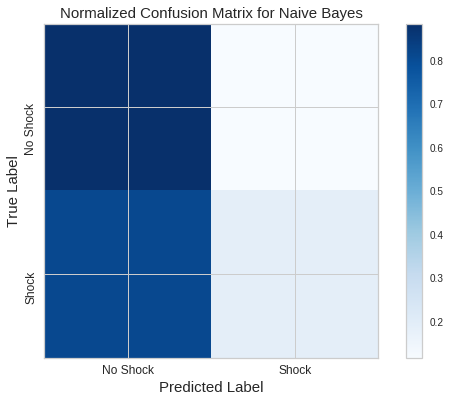

In [17]:
# Plot the normalized confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized Confusion Matrix for Naive Bayes')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized Confusion Matrix for Naive Bayes')
plt.savefig('plot_norm_confusion_matrix')
plt.show()

### Let's see how K-Nearest Neighbor does?

In [18]:
from sklearn.neighbors import KNeighborsClassifier  
knn = KNeighborsClassifier(n_neighbors=5)  
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Print classification report 
clr = classification_report(y_test, y_pred, target_names=target_names)
print(clr)

              precision    recall  f1-score   support

    No Shock       0.77      0.91      0.83     28215
       Shock       0.31      0.14      0.19      8735

   micro avg       0.72      0.72      0.72     36950
   macro avg       0.54      0.52      0.51     36950
weighted avg       0.66      0.72      0.68     36950



Normalized Confusion Matrix for K-Nearest Neighbor
[[0.91 0.09]
 [0.86 0.14]]


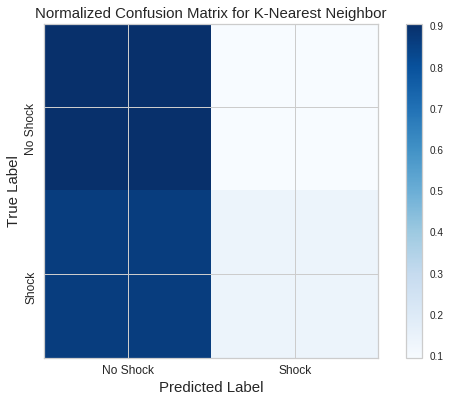

In [19]:
# Plot the normalized confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized Confusion Matrix for K-Nearest Neighbor')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized Confusion Matrix for K-Nearest Neighbor')
plt.savefig('plot_norm_confusion_matrix')
plt.show()

### Let's make this more interesting with Multi-layer Perceptron Neural Network

In [20]:
# How about a Multi-layer Perceptron neural network model?
from sklearn.neural_network import MLPClassifier

mlpnn = MLPClassifier(solver='lbfgs', alpha=1e-5, random_state=1)

mlpnn.fit(X_train, y_train)                         
MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=400, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=400, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [21]:
# Run the fitted model to get a prediction for the test data
y_pred = mlpnn.predict(X_test)

# Print classification report 
clr = classification_report(y_test, y_pred, target_names=target_names)
print(clr)

              precision    recall  f1-score   support

    No Shock       0.78      0.76      0.77     28215
       Shock       0.29      0.31      0.30      8735

   micro avg       0.66      0.66      0.66     36950
   macro avg       0.54      0.54      0.54     36950
weighted avg       0.67      0.66      0.66     36950



What would our model look like if we scaled X?

Normalized Confusion Matrix
[[0.76 0.24]
 [0.69 0.31]]


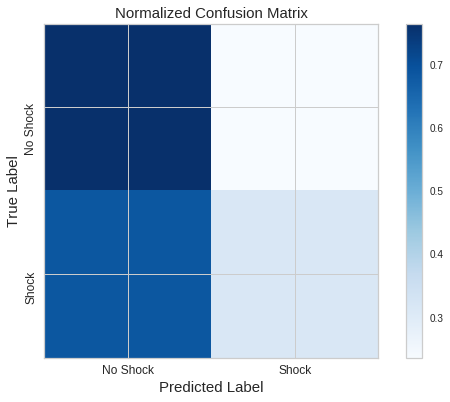

In [22]:
# Plot the normalized confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized Confusion Matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized Confusion Matrix')
plt.savefig('plot_norm_confusion_matrix')
plt.show()

### Adjusting the parameters for the MLPClassifier:

MLP results varied depending on the solver but not other parameters. I started with 'lbfgs', since that's what my example code used. That didn't work very well (f1-score 0.82), so on the advice of stackoverflow, I tried 'sgd', giving f1-score 0.86. I tried the 'adam' solver but I got a warning that it wasn't converging.  I gave it four hidden layers but that didn't help. Going back to the 'sgd solver, I also adjusted the number of hidden layers a few times, going up to four, but f1 stayed the same. I doubled the number of iterations to 400, which also had no effect on f1, so I se

In [24]:
# How about a Multi-layer Perceptron neural network model?
from sklearn.neural_network import MLPRegressor
#solver='lbfgs', alpha=1e-5, random_state=1
mlpnnr = MLPRegressor(solver='lbfgs', alpha=1e-5, random_state=1)

mlpnnr.fit(X_train, y_train)                         
MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=400, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=400, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)